In [257]:
# import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,DenseFeatures


from google.cloud import bigquery
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

tf.__version__

'2.11.0'

In [258]:
#!gsutil cp gs://smart-ml-pongthorn/incident-train-data/TrainEval_Incident.csv data

In [259]:
cateCols=['sla','product_type','brand','service_type','incident_type']
numbericCols=['open_to_close_hour','response_to_resolved_hour']

unusedCols=['severity_id','severity_name','label_binary_severity']
labelCol='label_multi_severity'


model_dir='tf1_multi_model'

# df['label_multi_severity'] =df['severity_name'].map({'Cosmatic':0,'Minor': 1, "Major": 2, "Critical": 3}) 

In [260]:
def load_ml_data(data_path):
 df=pd.read_csv(data_path)
 df =df.drop(columns=unusedCols)
 return df
    
root_path='../../data'    
train = load_ml_data(f"{root_path}/train_incident.csv")
# val=train.copy()
val=load_ml_data(f"{root_path}/validation_incident.csv")
# test =val.copy()
test =load_ml_data(f"{root_path}/test_incident.csv")

labelList=list(train[labelCol].unique())
print(labelList)
nLabel=len(labelList)
print(f"No target label : {nLabel}")

# sr_predict=df.iloc[-1,:]
# df=df.iloc[0:len(df)-1,:]
                 
print(train.info())
train.tail()

[2, 1, 3, 0]
No target label : 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1714 entries, 0 to 1713
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sla                        1714 non-null   object 
 1   product_type               1714 non-null   object 
 2   brand                      1714 non-null   object 
 3   service_type               1714 non-null   object 
 4   incident_type              1714 non-null   object 
 5   open_to_close_hour         1714 non-null   float64
 6   response_to_resolved_hour  1714 non-null   float64
 7   label_multi_severity       1714 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 107.2+ KB
None


,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour,label_multi_severity
1709,8x5 4Hrs Response Time,Storage,NetApp,Incident,Hard Disk Drive Failure,47.966667,5.000000,2
1710,24x7 4Hrs Response Time,Storage,NetApp,Incident,Hard Disk Drive Failure,7.716667,4.683333,2
1711,24x7 4Hrs Response Time,Storage,NetApp,Incident,Hard Disk Drive Failure,18.000000,18.000000,1
1712,24x7 4Hrs Resolution Time,Hardware,Oracle,Incident,System Board Failure,287.000000,285.733333,2
1713,24x7 4Hrs Resolution Time,Storage,NetApp,Incident,Hard Disk Drive Failure,8.983333,8.550000,1


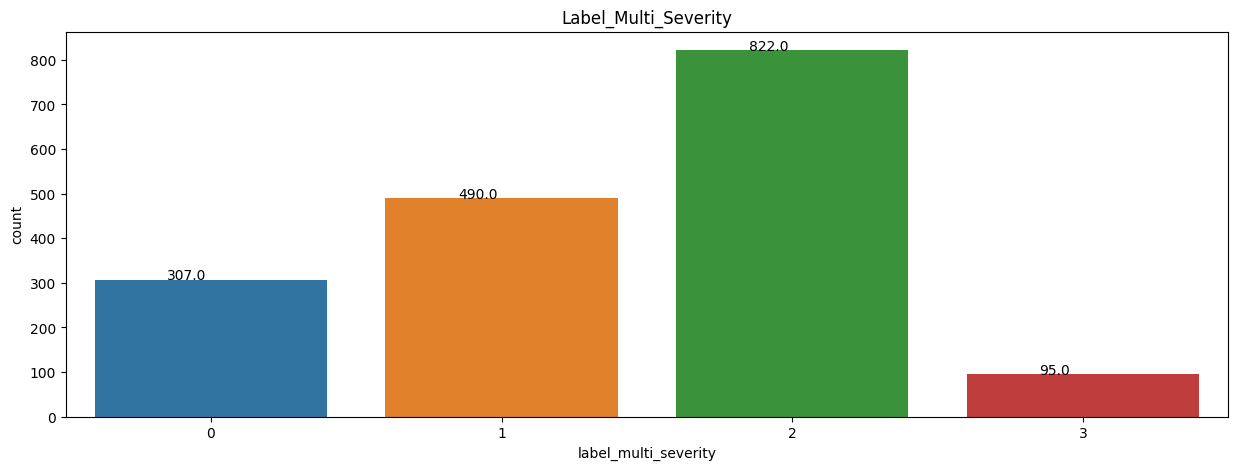

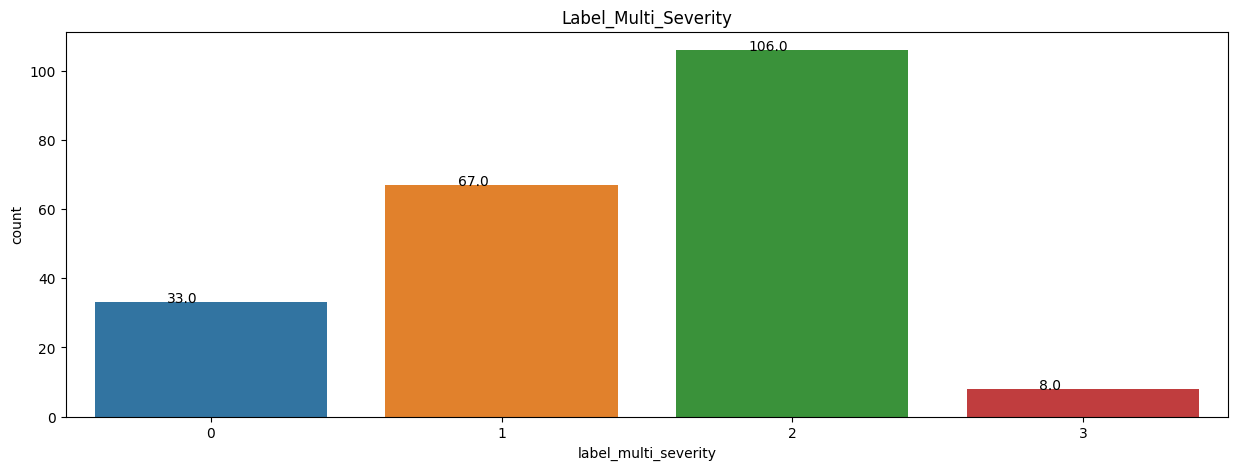

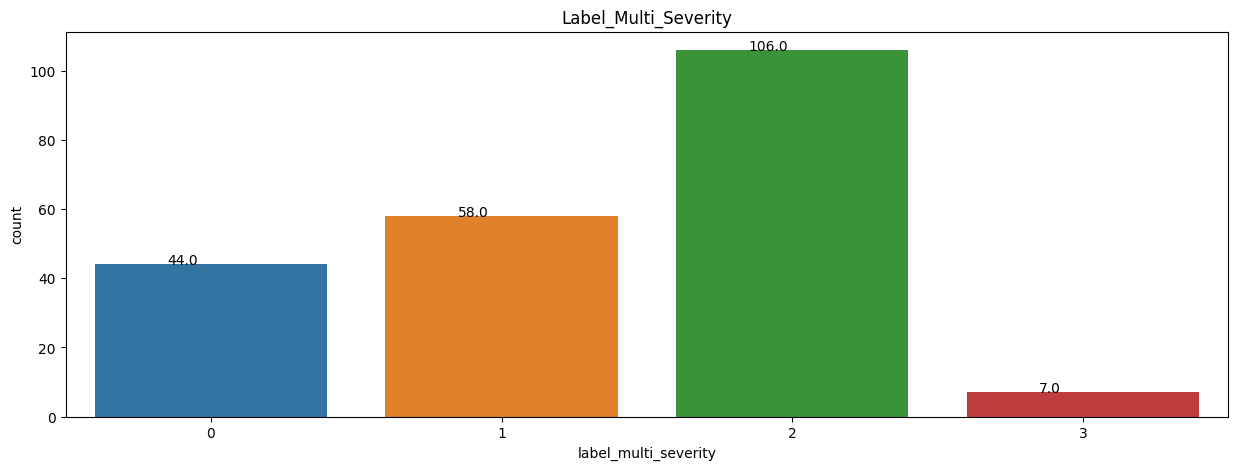

In [261]:
def plot_class(df):
    fig , ax = plt.subplots(figsize=(15,5))
    ax =sns.countplot(x=labelCol, data=df,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title(labelCol.title())
    plt.show()
    
plot_class(train)
plot_class(val)
plot_class(test)

In [262]:
# labelsTRain  = tf.keras.utils.to_categorical(train[labelCol], num_classes=nLabel)
# print(type(labelsTRain))


In [263]:
def multiple_label_df_to_dataset(dataframe, shuffle=True, batch_size=32):
  features = dataframe.copy()
  labels = features.pop(labelCol)
  labels  = tf.keras.utils.to_categorical(labels, num_classes=nLabel)
    
  ds = tf.data.Dataset.from_tensor_slices(( dict(features), labels ))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(features))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds
     
     

In [264]:
print("Explore Data from Tensor before keras data processing")
batch_size = 5
train_ds =multiple_label_df_to_dataset(train, batch_size=batch_size)

[(train_features, label_batch)] = train_ds.take(1)
print("========Features==========")
print('Every feature:', list(train_features.keys()))
print('product_type:', train_features['product_type'])
print('open_to_close_hour:', train_features['open_to_close_hour'])
print("========Labels==========")
print(f'{label_batch }')

Explore Data from Tensor before keras data processing
========Features==========
Every feature: ['sla', 'product_type', 'brand', 'service_type', 'incident_type', 'open_to_close_hour', 'response_to_resolved_hour']
product_type: tf.Tensor([b'Software' b'Hardware' b'Server' b'Software' b'Tape Library'], shape=(5,), dtype=string)
open_to_close_hour: tf.Tensor([144.61666667  52.         140.91666667   7.         103.        ], shape=(5,), dtype=float64)
========Labels==========
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]


In [265]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization(axis=None)

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [266]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_tokens=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))
     

In [267]:
hour_col = train_features['open_to_close_hour']
layer = get_normalization_layer('open_to_close_hour', train_ds)
layer(hour_col)

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 0.18711221, -0.1635212 ,  0.17310455, -0.33388475,  0.02955748],
      dtype=float32)>

In [268]:
# total no type+unkonw
type_col = train_features['product_type']
layer = get_category_encoding_layer('product_type', train_ds, 'string')
layer(type_col)

<tf.Tensor: shape=(11,), dtype=float32, numpy=array([0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0.], dtype=float32)>

# Process Data 

In [269]:
batch_size =32
train_ds = multiple_label_df_to_dataset (train, batch_size=batch_size)
# for element in train_ds.as_numpy_iterator():
#     print(element)

In [270]:
val_ds = multiple_label_df_to_dataset(val, batch_size=batch_size)
test_ds = multiple_label_df_to_dataset(test, batch_size=batch_size)

In [271]:
all_inputs = []
encoded_features = []

In [272]:
# Numeric features.
for header in numbericCols:
  print(header)  
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

open_to_close_hour
response_to_resolved_hour


In [273]:
# Categorical features encoded as string.
categorical_cols = cateCols
for header in categorical_cols:
  print(header)  
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string')
                                        
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)


sla
product_type
brand
service_type
incident_type


In [274]:
all_features = tf.keras.layers.concatenate(encoded_features)

x = tf.keras.layers.Dense(32, activation="relu")(all_features)
# x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
# x = tf.keras.layers.Dropout(0.1)(x)
output = tf.keras.layers.Dense(nLabel,activation=tf.nn.softmax)(x)

model = tf.keras.Model(all_inputs, output)


model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(),metrics=["accuracy"])
model.summary()    

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sla (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 product_type (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 brand (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 service_type (InputLayer)      [(None, 1)]          0           []                               
                                                                                           

In [275]:
EPOCHS = 100
BATCH_SIZE = 32


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
history =model.fit(train_ds, validation_data=val_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks = [early_stopping])
# history =model.fit(train_ds,verbose=1,validation_data=val_ds,epochs=EPOCHS,batch_size=BATCH_SIZE)


Epoch 1/100
54/54 [==============================] - 4s 22ms/step - loss: 1.2676 - accuracy: 0.4761 - val_loss: 1.0920 - val_accuracy: 0.5748
Epoch 2/100
54/54 [==============================] - 0s 5ms/step - loss: 0.9731 - accuracy: 0.6412 - val_loss: 0.8791 - val_accuracy: 0.6215
Epoch 3/100
54/54 [==============================] - 0s 5ms/step - loss: 0.8192 - accuracy: 0.6832 - val_loss: 0.8027 - val_accuracy: 0.6308
Epoch 4/100
54/54 [==============================] - 0s 5ms/step - loss: 0.7643 - accuracy: 0.6826 - val_loss: 0.7677 - val_accuracy: 0.6542
Epoch 5/100
54/54 [==============================] - 0s 5ms/step - loss: 0.7358 - accuracy: 0.6960 - val_loss: 0.7471 - val_accuracy: 0.6916
Epoch 6/100
54/54 [==============================] - 0s 5ms/step - loss: 0.7162 - accuracy: 0.7170 - val_loss: 0.7325 - val_accuracy: 0.6963
Epoch 7/100
54/54 [==============================] - 0s 6ms/step - loss: 0.7002 - accuracy: 0.7147 - val_loss: 0.7229 - val_accuracy: 0.7150
Epoch 8/100


In [276]:
loss, accuracy = model.evaluate(val_ds)
print("Average Accuracy on Eveluation", accuracy)
loss, accuracy = model.evaluate(test_ds)
print("Average Accuracy  on Test", accuracy)
     

7/7 [==============================] - 0s 4ms/step - loss: 0.7082 - accuracy: 0.7243
Average Accuracy on Eveluation 0.7242990732192993
7/7 [==============================] - 0s 5ms/step - loss: 0.6828 - accuracy: 0.7163
Average Accuracy  on Test 0.7162790894508362


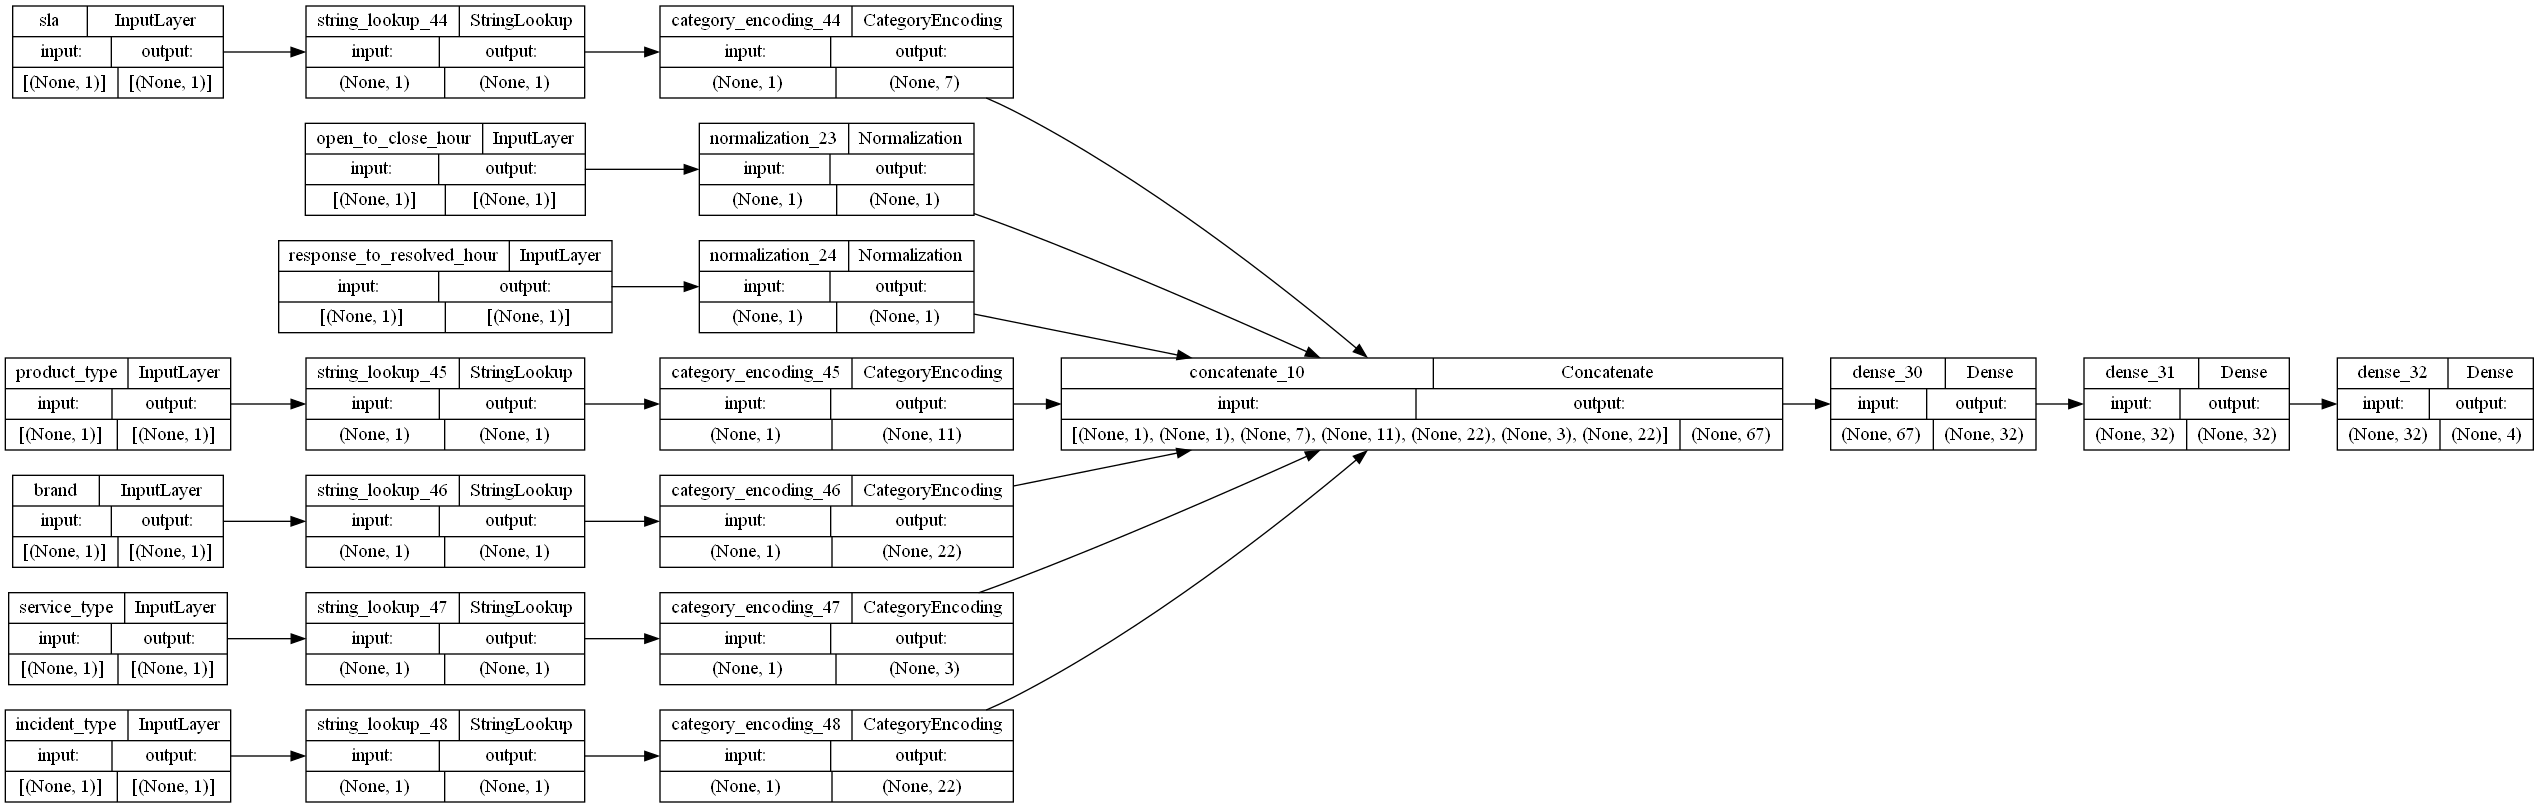

In [277]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [278]:
model.save(model_dir)


INFO:tensorflow:Assets written to: tf1_multi_model\assets


INFO:tensorflow:Assets written to: tf1_multi_model\assets


In [279]:
reloaded_model = tf.keras.models.load_model(model_dir)

In [280]:
#label_binary_severity
sample={"sla":"24x7 4Hrs Response Time",
        "product_type":"Server",
        "brand":"VMWare",                
        "service_type":"Incident",
        "incident_type":"General Incident",
        "open_to_close_hour":8.50,
        "response_to_resolved_hour":6.000000 \
       }

print(sample)
              
print("===============================================================================================================")    
print("input t0 predict")    
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
print(input_dict)

predictionList = reloaded_model.predict(input_dict)
print(predictionList)
prob = tf.nn.sigmoid(predictionList[0])
print(f"{(100 * prob)} %  as Severity")   

{'sla': '24x7 4Hrs Response Time', 'product_type': 'Server', 'brand': 'VMWare', 'service_type': 'Incident', 'incident_type': 'General Incident', 'open_to_close_hour': 8.5, 'response_to_resolved_hour': 6.0}
input t0 predict
{'sla': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'24x7 4Hrs Response Time'], dtype=object)>, 'product_type': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Server'], dtype=object)>, 'brand': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'VMWare'], dtype=object)>, 'service_type': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Incident'], dtype=object)>, 'incident_type': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'General Incident'], dtype=object)>, 'open_to_close_hour': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([8.5], dtype=float32)>, 'response_to_resolved_hour': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([6.], dtype=float32)>}
1/1 [==============================] - 1s 512ms/step
[[0.01209288 0.1728617  0.79734194

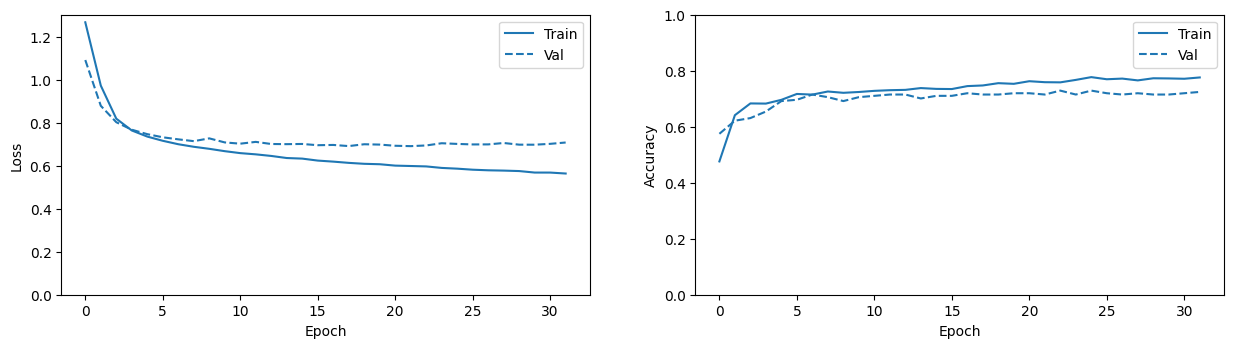

In [281]:
plt.figure(figsize=(15,8))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics =  ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(history)

In [237]:
# from explainable_ai_sdk.metadata.tf.v2 import SavedModelMetadataBuilder
# import explainable_ai_sdk

# model_builder = SavedModelMetadataBuilder(model_dir)
# metadata = model_builder.get_metadata()
# print(metadata)

In [274]:
# # Update these to your own GCP project and model
# PROJECT_ID = 'pongthorn'
# REGION = "asia-southeast1"  # @param {type: "string"}
# MODEL_BUCKET = 'gs://tf1-incident-pongthorn'

# !gsutil mb -l$REGION $MODEL_BUCKET

In [275]:
# !gsutil -m cp -r ./$model_dir/* $MODEL_BUCKET/model

# Deploy the model

In [385]:
# MODEL = 'tf1_incident'
# VERSION = 'v1'
# model_path = MODEL_BUCKET + '/model'

In [392]:
# !gcloud ai-platform models create $MODEL --region=$REGION

In [ ]:

# METRICS = [
#       keras.metrics.TruePositives(name='tp'),
#       keras.metrics.FalsePositives(name='fp'),
#       keras.metrics.TrueNegatives(name='tn'),
#       keras.metrics.FalseNegatives(name='fn'), 
#       keras.metrics.BinaryAccuracy(name='accuracy'),
#       keras.metrics.Precision(name='precision'),
#       keras.metrics.Recall(name='recall'),
#       keras.metrics.AUC(name='auc'),
# ]
